In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from jupyterthemes import jtplot
jtplot.style()

In [3]:
data_path = 'ex8_movies.mat'
data = sio.loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])


In [10]:
Y = data['Y']
R = data['R']
print(Y.shape)
print("Average rating of first movie: np.mean(Y[0, R[0] == 1])")

(1682, 943)
Average rating of first movie: np.mean(Y[0, R[0] == 1])


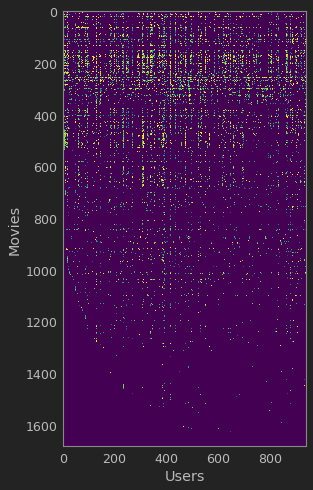

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
ax.set_ylabel('Movies')
ax.set_xlabel('Users')
ax.imshow(Y)

In [114]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lamb):
    X = params[:num_movies*num_features].reshape([num_movies, num_features])
    Theta = params[num_movies*num_features:].reshape([num_users, num_features])
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    grad = 0
    J_unreg = (1/2) * np.sum(((X@Theta.T - Y)*R)**2)
    J = J_unreg + (lamb/2)*(np.sum(X**2) + np.sum(Theta**2))
        
    for i in range(num_movies):
        X_grad[i, :] = ((X[i, :] @ Theta.T - Y[i, :]) * R[i, :]) @ Theta

    for i in range(num_users):
        Theta_grad[i, :] = ((X @ Theta[i, :].T - Y[:, i]) * R[:, i]).T @ X

    X_grad =  X_grad + lamb*X
    Theta_grad =  Theta_grad + lamb*Theta
        
    grad = np.r_[X_grad, Theta_grad].ravel()
    return J, grad

In [115]:
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data_path2 = 'ex8_movieParams.mat'
data2 = sio.loadmat(data_path2)
X_pre = data2['X']
Theta_pre = data2['Theta']
num_users = 4
num_movies = 5
num_features = 3
X_pre = X_pre[:num_movies, :num_features]
Theta_pre = Theta_pre[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [116]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Returns
    -------
    numgrad : array_like
        The numerical gradient with respect to theta. Has same shape as theta.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

def checkCostFunction(cofiCostFunc, lambda_=0.):
    # Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]

    params = np.concatenate([X.ravel(), Theta.ravel()])
    numgrad = computeNumericalGradient(
        lambda x: cofiCostFunc(x, Y, R, num_users, num_movies, num_features, lambda_), params)

    cost, grad = cofiCostFunc(params, Y, R, num_users,num_movies, num_features, lambda_)

    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)

In [117]:
J, grad = cofi_cost_func(np.r_[X_pre, Theta_pre].ravel(), Y,
                   R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters: ', J)
print("Check gradients by running checkNNGradients")
checkCostFunction(cofi_cost_func)

Cost at loaded parameters:  22.224603725685675
Check gradients by running checkNNGradients
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.18829597  0.18829597]
 [ 0.918264    0.918264  ]
 [ 4.42205746  4.42205746]
 [-0.28407128 -0.28407128]
 [ 6.57162668  6.57162668]
 [ 3.26975008  3.26975008]
 [-0.07027354 -0.07027354]
 [ 0.12932582  0.12932582]
 [ 2.44872809  2.44872809]
 [ 0.05566429  0.05566429]
 [-0.18733404 -0.18733404]
 [-0.15914486 -0.15914486]
 [ 2.20118421  2.20118421]
 [ 3.62806029  3.62806029]
 [ 1.90129826  1.90129826]
 [-4.07058505 -4.07058505]
 [-6.4429318  -6.4429318 ]
 [-3.31825542 -3.31825542]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.6114335   0.6114335 ]
 [-0.05418534 -0.05418534]
 [-0.96660337 -0.96660337]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative 

In [118]:
J, grad = cofi_cost_func(np.r_[X_pre, Theta_pre].ravel(), Y,
                   R, num_users, num_movies, num_features, 1.5)
print("Cost at loaded parameters (lambda = 1.5): ", J)

Cost at loaded parameters (lambda = 1.5):  31.34405624427422


In [119]:
checkCostFunction(cofi_cost_func, 1.5)

[[ -5.41647118  -5.41647118]
 [ -9.09455141  -9.09455141]
 [ -5.84837127  -5.84837127]
 [  9.87490702   9.87490702]
 [  9.88409118   9.88409118]
 [  9.95373902   9.95373902]
 [  0.80274184   0.80274184]
 [ -2.56814821  -2.56814821]
 [  1.85195477   1.85195477]
 [  0.72391844   0.72391844]
 [ -0.27330474  -0.27330474]
 [ -1.73395863  -1.73395863]
 [  1.14082511   1.14082511]
 [  1.54416536   1.54416536]
 [  3.98349065   3.98349065]
 [ -0.2927768   -0.2927768 ]
 [  0.26561415   0.26561415]
 [  1.4694275    1.4694275 ]
 [ -4.80280927  -4.80280927]
 [ -0.83821375  -0.83821375]
 [ -3.59917777  -3.59917777]
 [ -7.12887364  -7.12887364]
 [-10.14611243 -10.14611243]
 [ -7.20383862  -7.20383862]
 [  6.40872996   6.40872996]
 [  9.73940732   9.73940732]
 [  6.48397249   6.48397249]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1